<a href="https://colab.research.google.com/github/christopherlh2005/molecule-generation/blob/main/DL_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datasets import load_dataset

dataset = load_dataset("alagesse/gnn-datasets", "qm9-smiles")
print(dataset)
print(dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['mol_id', 'smiles', 'target'],
        num_rows: 110000
    })
    validation: Dataset({
        features: ['mol_id', 'smiles', 'target'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['mol_id', 'smiles', 'target'],
        num_rows: 10831
    })
})
{'mol_id': 70397, 'smiles': '[H]C1=C([H])[C@@]2([H])[C@@]3([H])C([H])([H])[C@]1([H])C([H])([H])[C@@]23C([H])([H])[H]', 'target': [0.48890000581741333, 86.0199966430664, -5.918476581573486, 0.7347074151039124, 6.653183937072754, 978.1151123046875, 5.064882278442383, -9523.521484375, -9523.328125, -9523.302734375, -9524.359375, 30.582000732421875, -91.39586639404297, -92.01201629638672, -92.5261001586914, -85.19295501708984, 2.8261098861694336, 1.7382899522781372, 1.5919100046157837]}


In [ ]:
import re
from collections import Counter

SMILES_PATTERN = re.compile(r"(\%\d\d|Br|Cl|\[[^\]]+\]|.)")

def tokenize_smiles(smiles: str):
    return SMILES_PATTERN.findall(smiles)

# Build vocab on train split
train_smiles = dataset["train"]["smiles"]

counter = Counter()
for s in train_smiles:
    counter.update(tokenize_smiles(s))

# Special tokens
PAD = "<PAD>"
BOS = "<BOS>"
EOS = "<EOS>"
UNK = "<UNK>"

special_tokens = [PAD, BOS, EOS, UNK]
tokens = special_tokens + sorted(counter.keys())

token2idx = {tok: i for i, tok in enumerate(tokens)}
idx2token = {i: tok for tok, i in token2idx.items()}

pad_idx = token2idx[PAD]
bos_idx = token2idx[BOS]
eos_idx = token2idx[EOS]
unk_idx = token2idx[UNK]

vocab_size = len(tokens)
vocab_size

38

In [ ]:
MAX_LEN = 52  # BOS + up to 50 tokens + EOS

def encode_smiles(smiles: str, max_len: int = MAX_LEN):
    toks = tokenize_smiles(smiles)
    # truncate so BOS + toks + EOS <= max_len
    toks = toks[:max_len - 2]
    ids = [bos_idx] + [token2idx.get(t, unk_idx) for t in toks] + [eos_idx]
    # pad
    if len(ids) < max_len:
        ids += [pad_idx] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

def decode_ids(ids):
    toks = [
        idx2token[i]
        for i in ids
        if i not in (pad_idx, bos_idx, eos_idx)
    ]
    return "".join(toks)

# Quick sanity-check
sample_smi = train_smiles[0]
encoded = encode_smiles(sample_smi)
decoded = decode_ids(encoded)
sample_smi, decoded


('[H]C1=C([H])[C@@]2([H])[C@@]3([H])C([H])([H])[C@]1([H])C([H])([H])[C@@]23C([H])([H])[H]',
 '[H]C1=C([H])[C@@]2([H])[C@@]3([H])C([H])([H])[C@]1([H])C([H])([H])[C@@]23C([H])([H])[H]')

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class QM9SmilesDataset(Dataset):
    def __init__(self, smiles_list, max_len=MAX_LEN):
        self.smiles_list = smiles_list
        self.max_len = max_len

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, idx):
        seq_ids = torch.tensor(
            encode_smiles(self.smiles_list[idx], self.max_len),
            dtype=torch.long
        )
        return seq_ids

train_ds = QM9SmilesDataset(dataset["train"]["smiles"])
val_ds   = QM9SmilesDataset(dataset["validation"]["smiles"])

BATCH_SIZE = 128

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import math

class SmilesVAE(nn.Module):
    def __init__(
        self,
        vocab_size,
        pad_idx,
        bos_idx,
        eos_idx,
        emb_dim=128,
        enc_hidden_dim=256,
        latent_dim=64,
        dec_hidden_dim=256,
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.pad_idx = pad_idx
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.latent_dim = latent_dim

        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)

        # Encoder: bi-GRU
        self.encoder_gru = nn.GRU(
            emb_dim,
            enc_hidden_dim,
            batch_first=True,
            bidirectional=True,
        )

        # Latent
        self.fc_mu = nn.Linear(2 * enc_hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(2 * enc_hidden_dim, latent_dim)

        # Decoder
        self.decoder_gru = nn.GRU(
            emb_dim + latent_dim,
            dec_hidden_dim,
            batch_first=True,
        )
        self.fc_out = nn.Linear(dec_hidden_dim, vocab_size)

    def encode(self, x):
        """
        x: (B, L) token ids
        """
        emb = self.embedding(x)  # (B, L, E)
        _, h = self.encoder_gru(emb)  # h: (2, B, H_enc) since bidirectional & 1 layer
        # h[0] = forward last, h[1] = backward last
        h_cat = torch.cat([h[0], h[1]], dim=-1)  # (B, 2*H_enc)
        mu = self.fc_mu(h_cat)
        logvar = self.fc_logvar(h_cat)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, dec_input_ids):
        """
        z: (B, Z)
        dec_input_ids: (B, L_dec)   (shifted sequence starting from BOS)
        """
        emb = self.embedding(dec_input_ids)  # (B, L, E)
        # Repeat latent across time
        z_expanded = z.unsqueeze(1).expand(-1, emb.size(1), -1)  # (B, L, Z)
        dec_inputs = torch.cat([emb, z_expanded], dim=-1)  # (B, L, E+Z)

        dec_out, _ = self.decoder_gru(dec_inputs)  # (B, L, H_dec)
        logits = self.fc_out(dec_out)  # (B, L, vocab_size)
        return logits

    def forward(self, x):
        """
        x: (B, L) full sequence with BOS at pos 0 and EOS somewhere before end.
        We make decoder inputs = x[:, :-1], targets = x[:, 1:]
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)

        dec_inp = x[:, :-1]
        logits = self.decode(z, dec_inp)  # (B, L-1, V)

        return logits, mu, logvar


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmilesVAE(
    vocab_size=vocab_size,
    pad_idx=pad_idx,
    bos_idx=bos_idx,
    eos_idx=eos_idx,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def vae_loss(logits, targets, mu, logvar, pad_idx, beta):
    """
    logits: (B, L, V)
    targets: (B, L)
    """
    B, L, V = logits.shape

    # Flatten
    logits_flat = logits.reshape(B * L, V)
    targets_flat = targets.reshape(B * L)

    # Mask out PAD
    mask = targets_flat != pad_idx
    if mask.sum() == 0:
        recon_loss = torch.tensor(0.0, device=logits.device)
    else:
        recon_loss = F.cross_entropy(
            logits_flat[mask],
            targets_flat[mask],
            reduction="mean",
        )

    # KL divergence (batch mean)
    kl_loss = -0.5 * torch.mean(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    return recon_loss + beta * kl_loss, recon_loss, kl_loss


In [ ]:
import os
from tqdm.auto import tqdm

EPOCHS = 30
KL_WARMUP_EPOCHS = 10
CHECKPOINT_DIR = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def get_beta(epoch):
    if epoch >= KL_WARMUP_EPOCHS:
        return 1.0
    return epoch / KL_WARMUP_EPOCHS

best_val_loss = float('inf')

for epoch in range(1, EPOCHS + 1):
    model.train()
    beta = get_beta(epoch)
    train_recon = 0.0
    train_kl = 0.0
    train_batches = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch} [beta={beta:.2f}]")
    for batch in pbar:
        batch = batch.to(device)  # (B, L)
        optimizer.zero_grad()

        logits, mu, logvar = model(batch)
        targets = batch[:, 1:]  # (B, L-1)
        loss, recon, kl = vae_loss(
            logits,
            targets,
            mu,
            logvar,
            pad_idx=pad_idx,
            beta=beta,
        )
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_recon += recon.item()
        train_kl += kl.item()
        train_batches += 1

        pbar.set_postfix({
            "recon": f"{train_recon/train_batches:.4f}",
            "kl": f"{train_kl/train_batches:.4f}",
        })

    # quick val loss
    model.eval()
    val_loss_accum = 0.0
    val_recon = 0.0
    val_kl = 0.0
    val_batches = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            logits, mu, logvar = model(batch)
            targets = batch[:, 1:]
            loss, recon, kl = vae_loss(
                logits,
                targets,
                mu,
                logvar,
                pad_idx=pad_idx,
                beta=1.0,  # full KL for reporting
            )
            val_loss_accum += loss.item()
            val_recon += recon.item()
            val_kl += kl.item()
            val_batches += 1

    avg_val_loss = val_loss_accum / val_batches
    avg_val_recon = val_recon / val_batches
    avg_val_kl = val_kl / val_batches

    print(
        f"Epoch {epoch}: "
        f"train_recon={train_recon/train_batches:.4f}, "
        f"train_kl={train_kl/train_batches:.4f}, "
        f"val_loss={avg_val_loss:.4f}, "
        f"val_recon={avg_val_recon:.4f}, "
        f"val_kl={avg_val_kl:.4f}"
    )

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, "best_model.pt"))
        print(f"  [Checkpoint] New best model saved with loss {best_val_loss:.4f}")

    # Save latest checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_val_loss,
        'beta': beta,
    }, os.path.join(CHECKPOINT_DIR, "latest_checkpoint.pt"))

Epoch 1 [beta=0.10]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 1: train_recon=0.0353, train_kl=0.3693, val_loss=0.4191, val_recon=0.0322, val_kl=0.3868
  [Checkpoint] New best model saved with loss 0.4191


Epoch 2 [beta=0.20]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 2: train_recon=0.0352, train_kl=0.3358, val_loss=0.3753, val_recon=0.0401, val_kl=0.3352
  [Checkpoint] New best model saved with loss 0.3753


Epoch 3 [beta=0.30]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 3: train_recon=0.0408, train_kl=0.3060, val_loss=0.3530, val_recon=0.0464, val_kl=0.3066
  [Checkpoint] New best model saved with loss 0.3530


Epoch 4 [beta=0.40]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 4: train_recon=0.0487, train_kl=0.2832, val_loss=0.3400, val_recon=0.0556, val_kl=0.2844
  [Checkpoint] New best model saved with loss 0.3400


Epoch 5 [beta=0.50]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 5: train_recon=0.0560, train_kl=0.2638, val_loss=0.3263, val_recon=0.0627, val_kl=0.2636
  [Checkpoint] New best model saved with loss 0.3263


Epoch 6 [beta=0.60]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 6: train_recon=0.0631, train_kl=0.2463, val_loss=0.3115, val_recon=0.0684, val_kl=0.2431
  [Checkpoint] New best model saved with loss 0.3115


Epoch 7 [beta=0.70]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 7: train_recon=0.0723, train_kl=0.2310, val_loss=0.3108, val_recon=0.0779, val_kl=0.2329
  [Checkpoint] New best model saved with loss 0.3108


Epoch 8 [beta=0.80]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 8: train_recon=0.0828, train_kl=0.2169, val_loss=0.3043, val_recon=0.0895, val_kl=0.2148
  [Checkpoint] New best model saved with loss 0.3043


Epoch 9 [beta=0.90]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 9: train_recon=0.0938, train_kl=0.2023, val_loss=0.2990, val_recon=0.1025, val_kl=0.1964
  [Checkpoint] New best model saved with loss 0.2990


Epoch 10 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 10: train_recon=0.1051, train_kl=0.1886, val_loss=0.2994, val_recon=0.1144, val_kl=0.1850


Epoch 11 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 11: train_recon=0.1078, train_kl=0.1853, val_loss=0.3073, val_recon=0.1195, val_kl=0.1877


Epoch 12 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 12: train_recon=0.1092, train_kl=0.1839, val_loss=0.2980, val_recon=0.1163, val_kl=0.1817
  [Checkpoint] New best model saved with loss 0.2980


Epoch 13 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 13: train_recon=0.1092, train_kl=0.1824, val_loss=0.2974, val_recon=0.1162, val_kl=0.1812
  [Checkpoint] New best model saved with loss 0.2974


Epoch 14 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 14: train_recon=0.1100, train_kl=0.1818, val_loss=0.2990, val_recon=0.1196, val_kl=0.1794


Epoch 15 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 15: train_recon=0.1104, train_kl=0.1807, val_loss=0.2985, val_recon=0.1191, val_kl=0.1793


Epoch 16 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 16: train_recon=0.1109, train_kl=0.1803, val_loss=0.2967, val_recon=0.1171, val_kl=0.1796
  [Checkpoint] New best model saved with loss 0.2967


Epoch 17 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 17: train_recon=0.1098, train_kl=0.1800, val_loss=0.2963, val_recon=0.1186, val_kl=0.1778
  [Checkpoint] New best model saved with loss 0.2963


Epoch 18 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 18: train_recon=0.1098, train_kl=0.1797, val_loss=0.3002, val_recon=0.1199, val_kl=0.1802


Epoch 19 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 19: train_recon=0.1108, train_kl=0.1791, val_loss=0.2961, val_recon=0.1200, val_kl=0.1761
  [Checkpoint] New best model saved with loss 0.2961


Epoch 20 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 20: train_recon=0.1095, train_kl=0.1790, val_loss=0.2976, val_recon=0.1191, val_kl=0.1785


Epoch 21 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 21: train_recon=0.1091, train_kl=0.1790, val_loss=0.2941, val_recon=0.1144, val_kl=0.1797
  [Checkpoint] New best model saved with loss 0.2941


Epoch 22 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 22: train_recon=0.1088, train_kl=0.1786, val_loss=0.2943, val_recon=0.1160, val_kl=0.1784


Epoch 23 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 23: train_recon=0.1104, train_kl=0.1788, val_loss=0.2930, val_recon=0.1144, val_kl=0.1786
  [Checkpoint] New best model saved with loss 0.2930


Epoch 24 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 24: train_recon=0.1086, train_kl=0.1786, val_loss=0.2947, val_recon=0.1162, val_kl=0.1785


Epoch 25 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 25: train_recon=0.1081, train_kl=0.1784, val_loss=0.2942, val_recon=0.1151, val_kl=0.1791


Epoch 26 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 26: train_recon=0.1080, train_kl=0.1787, val_loss=0.2957, val_recon=0.1185, val_kl=0.1772


Epoch 27 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 27: train_recon=0.1078, train_kl=0.1786, val_loss=0.2956, val_recon=0.1177, val_kl=0.1779


Epoch 28 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 28: train_recon=0.1080, train_kl=0.1782, val_loss=0.2928, val_recon=0.1140, val_kl=0.1788
  [Checkpoint] New best model saved with loss 0.2928


Epoch 29 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 29: train_recon=0.1081, train_kl=0.1782, val_loss=0.2956, val_recon=0.1157, val_kl=0.1800


Epoch 30 [beta=1.00]:   0%|          | 0/859 [00:00<?, ?it/s]

Epoch 30: train_recon=0.1076, train_kl=0.1781, val_loss=0.2972, val_recon=0.1177, val_kl=0.1795


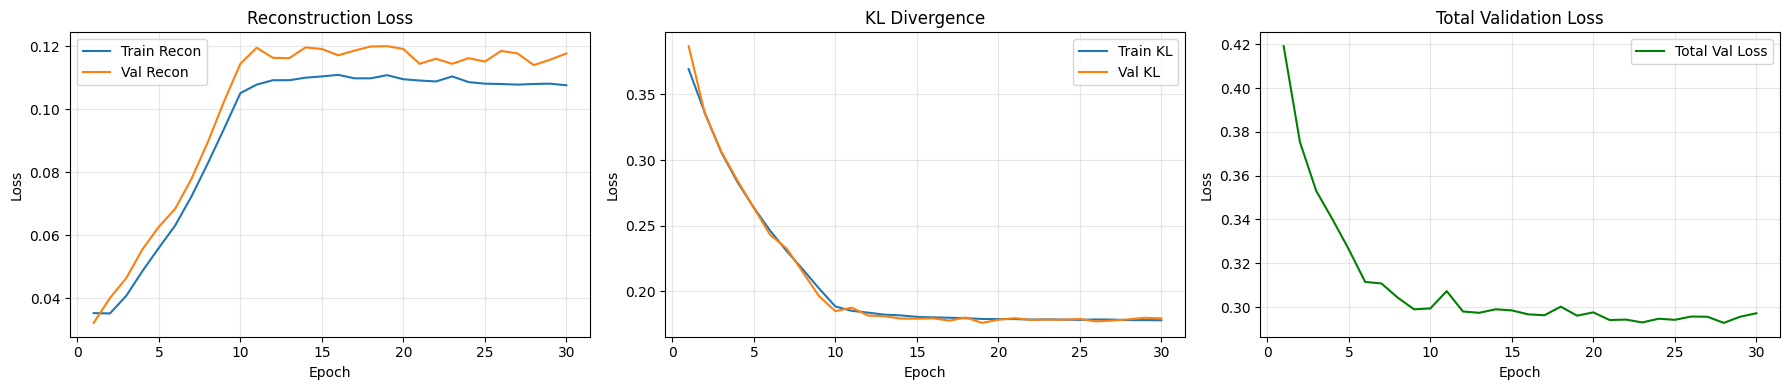

In [ ]:
import matplotlib.pyplot as plt
import re

# The logs provided in the prompt
raw_logs = """
Epoch 1: train_recon=0.0353, train_kl=0.3693, val_loss=0.4191, val_recon=0.0322, val_kl=0.3868
Epoch 2: train_recon=0.0352, train_kl=0.3358, val_loss=0.3753, val_recon=0.0401, val_kl=0.3352
Epoch 3: train_recon=0.0408, train_kl=0.3060, val_loss=0.3530, val_recon=0.0464, val_kl=0.3066
Epoch 4: train_recon=0.0487, train_kl=0.2832, val_loss=0.3400, val_recon=0.0556, val_kl=0.2844
Epoch 5: train_recon=0.0560, train_kl=0.2638, val_loss=0.3263, val_recon=0.0627, val_kl=0.2636
Epoch 6: train_recon=0.0631, train_kl=0.2463, val_loss=0.3115, val_recon=0.0684, val_kl=0.2431
Epoch 7: train_recon=0.0723, train_kl=0.2310, val_loss=0.3108, val_recon=0.0779, val_kl=0.2329
Epoch 8: train_recon=0.0828, train_kl=0.2169, val_loss=0.3043, val_recon=0.0895, val_kl=0.2148
Epoch 9: train_recon=0.0938, train_kl=0.2023, val_loss=0.2990, val_recon=0.1025, val_kl=0.1964
Epoch 10: train_recon=0.1051, train_kl=0.1886, val_loss=0.2994, val_recon=0.1144, val_kl=0.1850
Epoch 11: train_recon=0.1078, train_kl=0.1853, val_loss=0.3073, val_recon=0.1195, val_kl=0.1877
Epoch 12: train_recon=0.1092, train_kl=0.1839, val_loss=0.2980, val_recon=0.1163, val_kl=0.1817
Epoch 13: train_recon=0.1092, train_kl=0.1824, val_loss=0.2974, val_recon=0.1162, val_kl=0.1812
Epoch 14: train_recon=0.1100, train_kl=0.1818, val_loss=0.2990, val_recon=0.1196, val_kl=0.1794
Epoch 15: train_recon=0.1104, train_kl=0.1807, val_loss=0.2985, val_recon=0.1191, val_kl=0.1793
Epoch 16: train_recon=0.1109, train_kl=0.1803, val_loss=0.2967, val_recon=0.1171, val_kl=0.1796
Epoch 17: train_recon=0.1098, train_kl=0.1800, val_loss=0.2963, val_recon=0.1186, val_kl=0.1778
Epoch 18: train_recon=0.1098, train_kl=0.1797, val_loss=0.3002, val_recon=0.1199, val_kl=0.1802
Epoch 19: train_recon=0.1108, train_kl=0.1791, val_loss=0.2961, val_recon=0.1200, val_kl=0.1761
Epoch 20: train_recon=0.1095, train_kl=0.1790, val_loss=0.2976, val_recon=0.1191, val_kl=0.1785
Epoch 21: train_recon=0.1091, train_kl=0.1790, val_loss=0.2941, val_recon=0.1144, val_kl=0.1797
Epoch 22: train_recon=0.1088, train_kl=0.1786, val_loss=0.2943, val_recon=0.1160, val_kl=0.1784
Epoch 23: train_recon=0.1104, train_kl=0.1788, val_loss=0.2930, val_recon=0.1144, val_kl=0.1786
Epoch 24: train_recon=0.1086, train_kl=0.1786, val_loss=0.2947, val_recon=0.1162, val_kl=0.1785
Epoch 25: train_recon=0.1081, train_kl=0.1784, val_loss=0.2942, val_recon=0.1151, val_kl=0.1791
Epoch 26: train_recon=0.1080, train_kl=0.1787, val_loss=0.2957, val_recon=0.1185, val_kl=0.1772
Epoch 27: train_recon=0.1078, train_kl=0.1786, val_loss=0.2956, val_recon=0.1177, val_kl=0.1779
Epoch 28: train_recon=0.1080, train_kl=0.1782, val_loss=0.2928, val_recon=0.1140, val_kl=0.1788
Epoch 29: train_recon=0.1081, train_kl=0.1782, val_loss=0.2956, val_recon=0.1157, val_kl=0.1800
Epoch 30: train_recon=0.1076, train_kl=0.1781, val_loss=0.2972, val_recon=0.1177, val_kl=0.1795
"""

# Initialize storage
history = {
    'epoch': [],
    'train_recon': [], 'train_kl': [],
    'val_loss': [], 'val_recon': [], 'val_kl': []
}

# Regex to parse the log lines
pattern = re.compile(r"Epoch (\d+): train_recon=([\d\.]+), train_kl=([\d\.]+), val_loss=([\d\.]+), val_recon=([\d\.]+), val_kl=([\d\.]+)")

for line in raw_logs.strip().split('\n'):
    match = pattern.search(line)
    if match:
        history['epoch'].append(int(match.group(1)))
        history['train_recon'].append(float(match.group(2)))
        history['train_kl'].append(float(match.group(3)))
        history['val_loss'].append(float(match.group(4)))
        history['val_recon'].append(float(match.group(5)))
        history['val_kl'].append(float(match.group(6)))

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# 1. Reconstruction Loss
axes[0].plot(history['epoch'], history['train_recon'], label='Train Recon')
axes[0].plot(history['epoch'], history['val_recon'], label='Val Recon')
axes[0].set_title('Reconstruction Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. KL Divergence
axes[1].plot(history['epoch'], history['train_kl'], label='Train KL')
axes[1].plot(history['epoch'], history['val_kl'], label='Val KL')
axes[1].set_title('KL Divergence')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Total Validation Loss
axes[2].plot(history['epoch'], history['val_loss'], label='Total Val Loss', color='green')
axes[2].set_title('Total Validation Loss')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
import torch
import os
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model structure
# Note: Ensure the 'SmilesVAE' class and vocabulary variables (vocab_size, etc.)
# are defined by running the previous cells in the notebook.
try:
    model = SmilesVAE(
        vocab_size=vocab_size,
        pad_idx=pad_idx,
        bos_idx=bos_idx,
        eos_idx=eos_idx,
    ).to(device)
except NameError:
    print("Error: 'SmilesVAE' or vocabulary variables are not defined. Please run the cells defining the model and dataset first.")
    raise

# 2. Load from Google Drive
checkpoint_path = "/content/drive/MyDrive/Colab_Checkpoints/qm9_vae/best_model.pt"

if os.path.exists(checkpoint_path):
    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    print(f"Successfully loaded best model from {checkpoint_path}")
else:
    print(f"Checkpoint not found at {checkpoint_path}. Please check the path or ensure the file exists in Drive.")

Mounted at /content/drive
Successfully loaded best model from /content/drive/MyDrive/Colab_Checkpoints/qm9_vae/best_model.pt


In [ ]:
!pip install -q rdkit

from rdkit import Chem
from rdkit.Chem import AllChem

In [ ]:
# Check the local checkpoints folder
!ls -l checkpoints/

total 15948
-rw-r--r-- 1 root root  4080182 Dec  1 21:15 best_model.pt
-rw-r--r-- 1 root root 12247021 Dec  1 21:16 latest_checkpoint.pt


In [ ]:
from google.colab import drive
import shutil

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Create a destination folder in Drive
DRIVE_DEST = "/content/drive/MyDrive/Colab_Checkpoints/qm9_vae"
os.makedirs(DRIVE_DEST, exist_ok=True)

# 3. Copy files
shutil.copytree("checkpoints", DRIVE_DEST, dirs_exist_ok=True)
print(f"Checkpoints copied to {DRIVE_DEST}")

Mounted at /content/drive
Checkpoints copied to /content/drive/MyDrive/Colab_Checkpoints/qm9_vae


In [ ]:
def is_valid_smiles(smi: str) -> bool:
    return Chem.MolFromSmiles(smi) is not None

def sample_from_vae(
    model,
    n_samples=32,
    max_len=MAX_LEN,
    temperature=1.0,
    device=device,
):
    model.eval()
    samples = []

    with torch.no_grad():
        z = torch.randn(n_samples, model.latent_dim, device=device)

        for i in range(n_samples):
            z_i = z[i:i+1]  # (1, Z)
            # Start from BOS
            prev_id = torch.tensor([[bos_idx]], device=device)
            hidden = None
            generated_ids = [bos_idx]

            for t in range(max_len - 1):
                emb = model.embedding(prev_id)  # (1,1,E)
                z_step = z_i.unsqueeze(1)  # (1,1,Z)
                dec_in = torch.cat([emb, z_step], dim=-1)  # (1,1,E+Z)

                out, hidden = model.decoder_gru(dec_in, hidden)  # out: (1,1,H)
                logits = model.fc_out(out.squeeze(1))  # (1, V)
                logits = logits / temperature
                probs = F.softmax(logits, dim=-1)

                next_id = torch.multinomial(probs, num_samples=1).item()
                if next_id == eos_idx:
                    break

                generated_ids.append(next_id)
                prev_id = torch.tensor([[next_id]], device=device)

            smi = decode_ids(generated_ids)
            samples.append(smi)

    return samples

# Load best model state if exists
best_ckpt_path = os.path.join(CHECKPOINT_DIR, "best_model.pt")
if os.path.exists(best_ckpt_path):
    print(f"Loading best model from {best_ckpt_path}...")
    model.load_state_dict(torch.load(best_ckpt_path))
    print("Model loaded.")

# Sample a few
gen_smiles = sample_from_vae(model, n_samples=50, temperature=0.8)
gen_smiles[:10]

Loading best model from checkpoints/best_model.pt...
Model loaded.


['[H]C(=O)OC([H])([H])C(=O)C([H])([H])C([H])([H])C([H])([H])[H]',
 '[H]O[C@@]([H])(C([H])=O)[C@]([H])(C#N)C([H])([H])[H]',
 '[H]O[C@]1([H])[C@]([H])(C([H])([H])[H])[C@]2([H])C([H])([H])[C@@]1([H])[C@@]2([H])C([H])([H])',
 '[H]C1([H])C(=O)[C@@]([H])(C#N)C([H])([H])C([H])([H])C1([H])[H]',
 '[H]C1=C([H])[C@]2([H])C([H])([H])O[C@]([H])(C([H])([H])[H])[C@]2([H])C1([H])[H]',
 '[H]/N=C(\\N([H])C(=O)C#N)C([H])([H])O[H]',
 '[H]C1=C(N([H])[H])N2[C@@H](N1)[C@]1([H])C([H])([H])[C@]21[H]',
 '[H]OC([H])([H])[C@]1([H])C([H])([H])[C@@]([H])(C#C[H])C1([H])[H]',
 '[H]C([H])([H])[C@@]1([H])C([H])([H])OC([H])([H])[C@@]12C([H])([H])C([H])([H])C2([H])',
 '[H]C1=C([H])[C@]2([H])[NH2+][C+]([H])O[C@@]2([H])C1=O']

In [ ]:
all_qm9_smiles = set(dataset["train"]["smiles"]) \
               | set(dataset["validation"]["smiles"]) \
               | set(dataset["test"]["smiles"])

def compute_validity_and_uniqueness(samples):
    valid = []
    for smi in samples:
        valid.append(is_valid_smiles(smi))

    valid_smiles = [s for s, v in zip(samples, valid) if v]

    validity_rate = sum(valid) / len(samples) if samples else 0.0
    novelty_rate = (
        sum(1 for s in valid_smiles if s not in all_qm9_smiles) / len(valid_smiles)
        if valid_smiles else 0.0
    )

    return validity_rate, novelty_rate

validity, novelty = compute_validity_and_uniqueness(gen_smiles)
print(f"Validity: {validity*100:.2f}%")
print(f"Novelty (vs QM9): {novelty*100:.2f}%")


Validity: 98.00%
Novelty (vs QM9): 65.31%


[21:21:51] SMILES Parse Error: unclosed ring for input: '[H]O[C@@]1([H])C2=NOC([H])=C2C([H])([H])[H]'


In [ ]:
!pip install rdkit py3Dmol -q

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import py3Dmol

def smiles_to_3d_view(smiles, style="ballstick"):
    base = Chem.MolFromSmiles(smiles)
    if base is None:
        raise ValueError(f"Cannot parse SMILES: {smiles}")
    mol = Chem.AddHs(base)

    params = AllChem.ETKDGv3()
    params.randomSeed = 0xf00d

    status = AllChem.EmbedMolecule(mol, params)
    if status != 0 or mol.GetNumConformers() == 0:
        raise RuntimeError(f"EmbedMolecule failed (code {status}) for {smiles}")

    AllChem.UFFOptimizeMolecule(mol)

    mb = Chem.MolToMolBlock(mol)
    v = py3Dmol.view(width=500, height=500)
    v.addModel(mb, "sdf")

    if style == "stick":
        v.setStyle({"stick": {}})
    elif style == "sphere":
        v.setStyle({"sphere": {}})
    else:  # ball-and-stick
        v.setStyle({"stick": {}, "sphere": {"scale": 0.3}})

    v.zoomTo()
    return v

# sanity test – SHOULD SHOW 3D ETHANOL
v = smiles_to_3d_view("CCO")
v.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
smiles_list = [
    r'[H]C(=O)OC([H])([H])C(=O)C([H])([H])C([H])([H])C([H])([H])[H]',
    r'[H]O[C@@]([H])(C([H])=O)[C@]([H])(C#N)C([H])([H])[H]',
    r'[H]O[C@]1([H])[C@]([H])(C([H])([H])[H])[C@]2([H])C([H])([H])[C@@]1([H])[C@@]2([H])C([H])([H])',
    r'[H]C1([H])C(=O)[C@@]([H])(C#N)C([H])([H])C([H])([H])C1([H])[H]',
    r'[H]C1=C([H])[C@]2([H])C([H])([H])O[C@]([H])(C([H])([H])[H])[C@]2([H])C1([H])[H]',
    r'[H]/N=C(\N([H])C(=O)C#N)C([H])([H])O[H]',
    r'[H]C1=C(N([H])[H])N2[C@@H](N1)[C@]1([H])C([H])([H])[C@]21[H]',
    r'[H]OC([H])([H])[C@]1([H])C([H])([H])[C@@]([H])(C#C[H])C1([H])[H]',
    r'[H]C([H])([H])[C@@]1([H])C([H])([H])OC([H])([H])[C@@]12C([H])([H])C([H])([H])C2([H])',
    r'[H]C1=C([H])[C@]2([H])[NH2+][C+]([H])O[C@@]2([H])C1=O'
]

for i, smi in enumerate(smiles_list, start=1):
    print(f"Mol {i}")
    try:
        v = smiles_to_3d_view(smi, style="ballstick")
        v.show()
    except Exception as e:
        print("  FAILED:", e)


Mol 1


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Mol 2


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Mol 3


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Mol 4


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Mol 5


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Mol 6


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Mol 7
  FAILED: EmbedMolecule failed (code -1) for [H]C1=C(N([H])[H])N2[C@@H](N1)[C@]1([H])C([H])([H])[C@]21[H]
Mol 8


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Mol 9


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Mol 10


3Dmol.js failed to load for some reason. Please check your browser console for error messages.